In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from circle_fit import leastsq_circle
from skimage.draw import line
from skimage.transform import resize
from cv2 import equalizeHist, createCLAHE
import random
Image.MAX_IMAGE_PIXELS = 1000000000

img = Image.open('img.png')

In [58]:
class Rim(object):
    def __init__(self, coordinates, img):
        self.cropped = None
        self.target = None
        self.top = img.size[1]
        self.coords = []
        for coord in coordinates:
            coords = [float(x) for x in coord.split('\t')]
            coords[1] = self.top - coords[1]
            coords = tuple(coords)
            self.coords.append(coords)
        prev_crd = self.coords[-1]
        self.d = []
        for i, crd in enumerate(self.coords):
            d = np.sqrt(np.sum(np.square(np.array(crd) - np.array(prev_crd))))
            self.d.append(d)
            prev_crd = crd
        self.min_0 = min([x[0] for x in self.coords])
        self.min_1 = min([x[1] for x in self.coords])
        self.fit_circle()
        
    def fit_circle(self):
        """Fits a circle to the points on rim."""
        X0 = [x[0] for x in self.coords]
        X1 = [x[1] for x in self.coords]
        xc, yc, R, residu = leastsq_circle(X0, X1)
        self.c0 = xc
        self.c1 = yc
        self.r = R
        self.residual = residu
        self.res_ratio = self.residual/self.r
            
    def show(self, img):
        """Plots trace points in scatter plot."""
        scale = self.r * 3
        left = self.c0 - scale
        upper = self.c1 - scale
        right = self.c0 + scale
        lower = self.c1 + scale
        cropped = img.crop((left, upper, right, lower))
        fig, ax = plt.subplots()
        X0 = np.array([x[0] for x in self.coords])
        X1 = np.array([x[1] for x in self.coords])
        X0 = X0 - self.c0 + scale
        X1 = X1 - self.c1 + scale
        ax.imshow(np.array(cropped), cmap='Greys_r')
        ax.scatter(X0, X1);
        mean_d = np.array(self.d).mean()
        segments = []
        segment = []
        tol = 2.5
        for i, d in enumerate(self.d):
            if d > mean_d * tol and len(segment) > 1:
                segments.append(segment)
                segment = []
            else:
                segment.append(i+1)
        segments.append(segment)
        for segment in segments:
            ax.plot(X0[min(segment):max(segment)], X1[min(segment):max(segment)], color='yellow');
        if self.d[1] < mean_d * tol:
            x0 = [X0[0], X0[1]]
            x1 = [X1[0], X1[1]]
            ax.plot(x0, x1, color='yellow')
        if self.d[0] < mean_d * tol:
            x0 = [X0[-1], X0[0]]
            x1 = [X1[-1], X1[0]]
            ax.plot(x0, x1, color='yellow')
        circle = plt.Circle((scale, scale), self.r, color='r', fill=False)
        #ax.add_artist(circle)
        plt.axis('equal')
        plt.show();
        
    def create_target(self, img, in_dim=224, scale_factor=3):
        scale_factor = 3
        scale = self.r * scale_factor * 2
        left = self.c0 - scale
        upper = self.c1 - scale
        right = self.c0 + scale
        lower = self.c1 + scale
        cropped = img.crop((left, upper, right, lower))
        dim = cropped.size[0]
        target = np.zeros((dim, dim))
        mean_d = np.array(self.d).mean()
        for i, d in enumerate(self.d):
            if d < mean_d * 2.5:
                ln = line(
                    int(round(self.coords[i-1][1] - self.c1 + scale)), 
                    int(round(self.coords[i-1][0] - self.c0 + scale)), 
                    int(round(self.coords[i][1] - self.c1 + scale)), 
                    int(round(self.coords[i][0] - self.c0 + scale))
                )
                target[ln] = 255
        in_dim *= 2
        in_dim += 5
        in_dim = int(in_dim)
        target_image = Image.fromarray(np.uint8(target))
        cropped = cropped.resize((in_dim, in_dim), resample=PIL.Image.BILINEAR)
        target_image = target_image.resize((in_dim, in_dim), resample=PIL.Image.BILINEAR)
        self.cropped = cropped
        self.target = target_image
        return
    
    def get_pair(self, img, out_dim = 224, rotation=0, displace=(0,0), rescale=1):
        if self.cropped == None:
            self.create_target(img)
        dim = int(out_dim*rescale)
        buff = (self.cropped.size[0] - dim)//2
        left = buff + displace[0]
        right = buff + dim + displace[0]
        top = buff + displace[1]
        bottom = buff + dim + displace[1]
        to_crop = self.cropped.rotate(rotation)
        target = self.target.rotate(rotation)
        img = to_crop.crop((left, top, right, bottom))
        target = target.crop((left, top, right, bottom))
        if img.size[0] != out_dim:
            img = img.resize((out_dim, out_dim), resample=PIL.Image.BILINEAR)
            target = target.resize((out_dim, out_dim), resample=PIL.Image.BILINEAR)
        return img, target
        
def make_channels(input_image):
    """Converts image to three channels:
    1: unaltered image
    2: Histogram equalized image
    3: CLAHE image
    """
    ch1 = np.array(input_image)
    ch2 = equalizeHist(ch1)
    clahe = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    ch3 = clahe.apply(ch1)
    image = [ch1, ch2, ch3]
    image = [np.expand_dims(x, axis=-1) for x in image]
    image = np.concatenate(image, axis=-1)
    return image


In [59]:
with open('Rims.txt', 'r') as f:
    rims = f.read()

coords = rims.split('\n')
next_rim = []
rims = []
for coord in coords:
    if len(coord) == 2:
        rims.append(Rim(next_rim, img))
        next_rim = []
    else:
        next_rim.append(coord)

In [182]:
cutoff_r = 1000
use_rims = []
for rim in rims:
    if rim.r < cutoff_r:
        use_rims.append(rim)
        
print(len(use_rims), ' rims in set.')

holdout_prop = .1
holdout = int(holdout_prop * len(rims))
val_rims = []
train_rims = use_rims.copy()
random.shuffle(train_rims)
for i in range(holdout):
    val_rims.append(train_rims.pop())

754  rims in set.


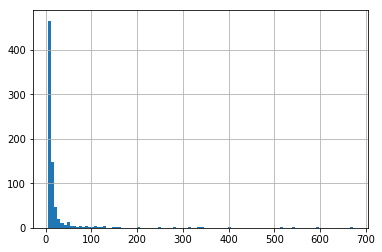

In [183]:
sizes = [x.r for x in use_rims]
np.argmax(sizes)
pd.Series(sizes).hist(bins=100);
plt.show();

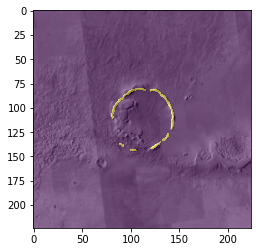

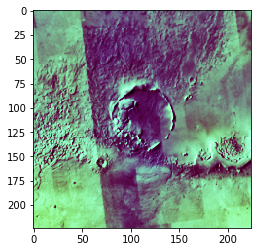

In [185]:
val = 700
up = val + 100
down = val - 100

for rim in rims:
    if down < rim.r < up:
        break
image, target = rim.get_pair(img, rotation=0, displace=(0, 0), rescale=1.2)
target = np.array(target)/255
target = np.where(np.array(target) > .001, 1, 0)
plt.imshow(np.array(image), cmap='Greys_r')
plt.imshow(target, alpha=.5)
plt.show();
plt.imshow(make_channels(image))
plt.show();

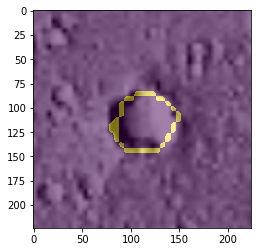

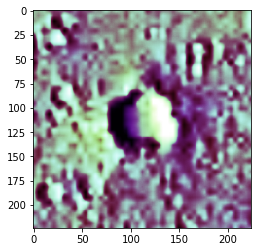

In [216]:


val = 5
up = val + 1
down = val - 1

for rim in rims:
    if down < rim.r < up:
        break
image, target = rim.get_pair(img, rotation=0, displace=(0, 0), rescale=1.2)
target = np.array(target)/255
thresh = get_thresh(rim.r)
target = np.where(np.array(target) > .5, 1, 0)
plt.imshow(np.array(image), cmap='Greys_r')
plt.imshow(target, alpha=.5)
plt.show();
plt.imshow(make_channels(image))
plt.show();

In [238]:
def get_thresh(radius):
    """Computes threshold for binarization."""
    if radius < 10:
        return .5
    if radius < 100:
        return 4/radius
    else:
        return 180/radius**2

def datagen(rims, img, val=False, batch_size=8):
    """Generates training batches."""
    X = []
    Y = []
    count = 0
    while True:
        if len(X) == batch_size:
            X = [np.expand_dims(x, axis=0) for x in X]
            X = np.concatenate(X, axis=0)
            Y = [np.expand_dims(y, axis=0) for y in Y]
            Y = np.concatenate(Y, axis=0)
            yield X, Y
            X = []
            Y = []
        else:
            if val:
                if count == len(rims):
                    count = 0
                image, target = rims[count].get_pair(img)
                count += 1
            elif not val:
                rim = random.choice(rims)
                rot = random.randint(0, 360)
                disp0 = random.randint(-3, 3)
                disp1 = random.randint(-3, 3)
                rescale = 1 + (random.random() - .5)*.4
                image, target = rim.get_pair(
                    img, 
                    rotation=rot, 
                    displace=(disp0, disp1),
                    rescale=rescale
                )
            image = make_channels(image)/255
            target = np.array(target)/255
            thresh = get_thresh(rim.r)
            target = np.where(target > thresh, 1, 0)
            X.append(image)
            Y.append(target)
                

In [239]:
val_gen = datagen(val_rims, img, val=True, batch_size=5)
train_gen = datagen(train_rims, img, val=False, batch_size=32)

In [240]:
X, Y = next(train_gen)

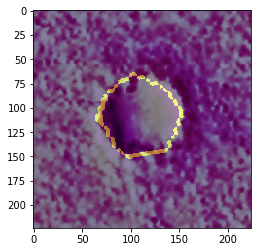

In [245]:
see = 3
plt.imshow(X[see])
plt.imshow(Y[see], alpha=.5)
plt.show();

In [246]:
import keras
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, Concatenate, Reshape
from keras.models import Model

Using TensorFlow backend.


In [247]:
def make_unet(dim=224, w=1):
    
    def conv_layer(n, w):
        """Standard 3x3 conv layer used in model."""
        return Conv2D(filters=n*w, kernel_size=(3,3), padding='same', activation='relu')
    
    def deconv_layer(n, w):
        """Standard 'deconvolution' layer used in model."""
        return Conv2DTranspose(filters=n*w, kernel_size=(2, 2), strides=2, activation='relu')
    
    inp = Input((224, 224, 3))
    x = BatchNormalization()(inp)
    x = conv_layer(2, w)(x)
    x = conv_layer(4, w)(x)
    mid1 = BatchNormalization()(x)
    x = MaxPooling2D()(mid1)
    x = conv_layer(4, w)(x)
    x = conv_layer(8, w)(x)
    mid2 = BatchNormalization()(x)
    x = MaxPooling2D()(mid2)
    x = conv_layer(8, w)(x)
    x = conv_layer(16, w)(x)
    mid3 = BatchNormalization()(x)
    x = MaxPooling2D()(mid3)
    x = conv_layer(16, w)(x)
    x = conv_layer(32, w)(x)
    x = conv_layer(32, w)(x)
    x = deconv_layer(16, w)(x)
    x = Concatenate()([mid3, x])
    x = conv_layer(16, w)(x)
    x = conv_layer(16, w)(x)
    x = deconv_layer(8, w)(x)
    x = Concatenate()([mid2, x])
    x = conv_layer(8, w)(x)
    x = conv_layer(8, w)(x)
    x = deconv_layer(4, w)(x)
    x = Concatenate()([mid1, x])
    x = conv_layer(4, w)(x)
    x = conv_layer(4, w)(x)
    x = Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='relu')(x)
    out = Reshape((224, 224))(x)
    
    model = Model(inputs=inp, outputs=out)
    
    return model

model = make_unet(w=8)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [248]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

model.compile(
    #optimizer=Adam(lr=.0002, beta_1=0.5),
    optimizer='adam',
    loss='binary_crossentropy'
)

callbacks = []
callbacks.append(ModelCheckpoint('best.h5', save_best_only=True, monitor='val_loss', verbose=True))

In [ ]:
val_steps = 75//5
steps = len(train_rims)//8
model.fit_generator(
    train_gen,
    steps_per_epoch=steps,
    epochs=100,
    validation_data = val_gen,
    validation_steps = val_steps,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/100
 4/84 [>.............................] - ETA: 1:01:50 - loss: 0.2758

51 51 278 278


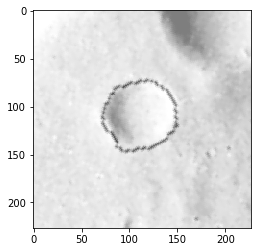

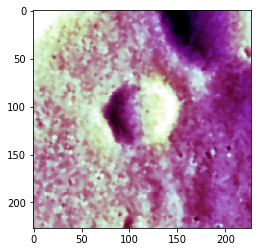

In [502]:
image, target = rims[255].get_pair(img, rotation=30, displace=(3, 3))
plt.imshow(np.array(image), cmap='Greys_r')
plt.imshow(np.array(target), cmap='Greys', alpha=.5)
plt.show();
plt.imshow(make_channels(image))
plt.show();

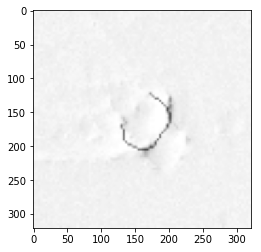

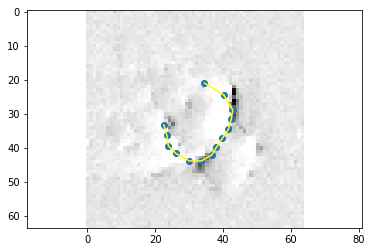

In [430]:
to_show = 69
rims[to_show].draw_bitmap(img)
plt.show();
rims[to_show].show(img)

/home/ubuntu/anaconda3/envs/mklear/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


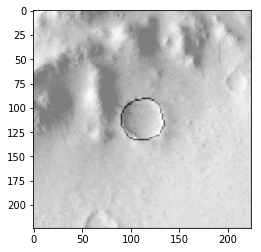

In [360]:
rims[340].draw_bitmap(img)
plt.show();

In [ ]:
len(rims)

In [134]:
left = 14900
upper = 14900
right = 15000
lower = 15000
left, upper, right, lower = rims[100].show(img)
img.crop((int(left), int(upper), int(right), int(lower)))

SystemError: tile cannot extend outside image

<PIL.Image.Image image mode=L size=39x0 at 0x7F1FBAEF7EB8>

In [125]:
img.crop((left, upper, right, lower))

SystemError: tile cannot extend outside image

<PIL.Image.Image image mode=L size=38x0 at 0x7F1FBB395470>

In [113]:
img.size

(33342, 22228)

In [128]:
img.crop((300, 221, 302, 219))

SystemError: tile cannot extend outside image

<PIL.Image.Image image mode=L size=2x0 at 0x7F1FBB2EA1D0>